In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np

# Hyperparameters initialization

In [2]:
BATCH_SIZE = 512
EPOCHS = 20
LEARNING_RATE = 0.001

# Preparing train and test datasets

In [3]:
(train_data, val_data, test_data), metadata = tfds.load('fashion_mnist',
                                                        split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                        with_info=True)
print(metadata.features)

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


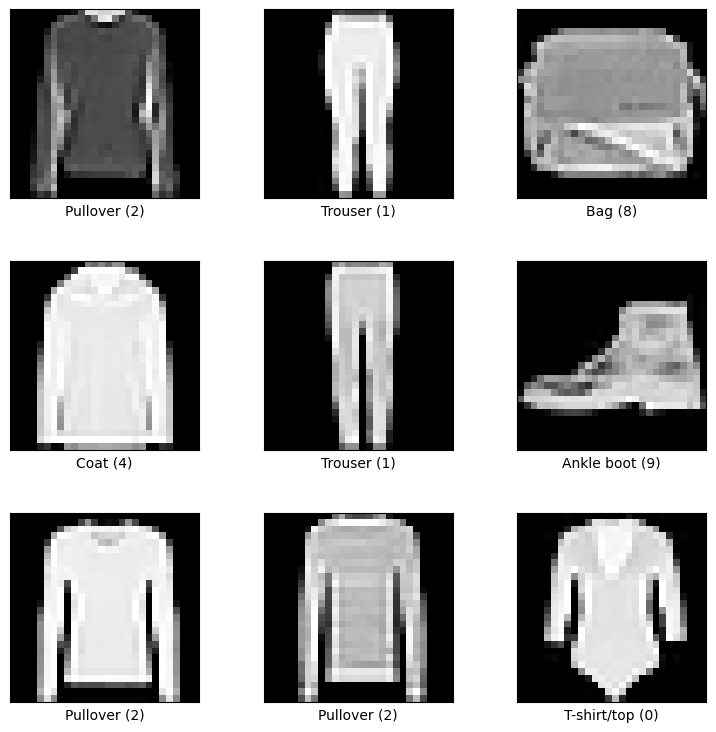

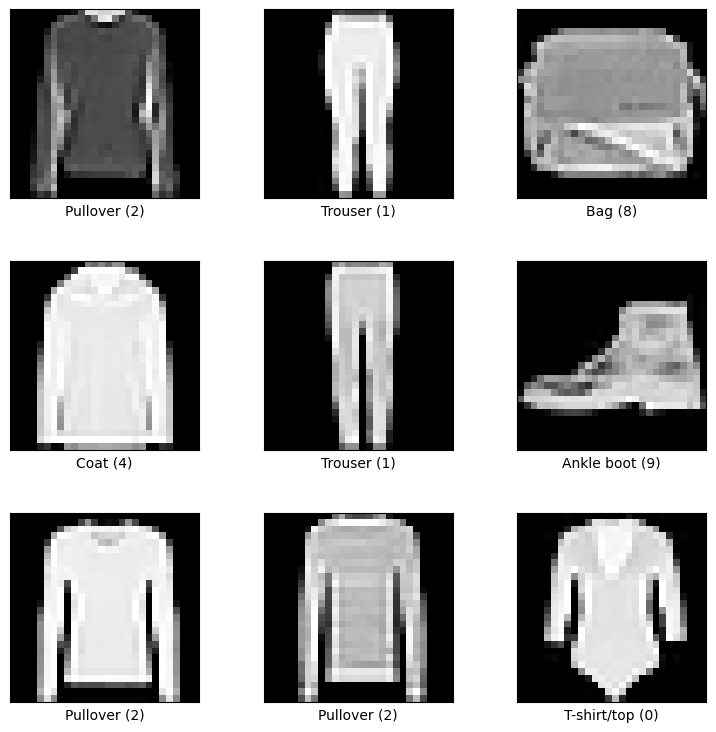

In [4]:
tfds.visualization.show_examples(train_data, metadata)

In [5]:
def preprocess(dataset):
    image = tf.cast(dataset['image'], dtype=tf.float32) / 255.
    label = tf.cast(dataset['label'], dtype=tf.float32)
    return image, label


train_data = train_data.map(preprocess).shuffle(buffer_size=1024).batch(BATCH_SIZE)
val_data = val_data.map(preprocess).batch(BATCH_SIZE)
test_data = test_data.map(preprocess).batch(BATCH_SIZE)

# Defining Classification Model

In [6]:
def simple_mlp_model(num_classes):
    input_ = tf.keras.layers.Input(shape=(28, 28, 1,))
    x = tf.keras.layers.Flatten()(input_)
    x = tf.keras.layers.Normalization()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output_ = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.models.Model(input_, output_, name='Classifier')

num_classes = metadata.features['label'].num_classes
model = simple_mlp_model(num_classes)
model.summary()

Model: "Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 784)            │         1,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,715 (924.67 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 1,569 (6.13 KB)

# Training model

In [7]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(LEARNING_RATE,
                                                             decay_steps=100000,
                                                             decay_rate=0.96)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data)

Epoch 1/20


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5907 - loss: 1.1677 - val_accuracy: 0.8248 - val_loss: 0.4886
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8161 - loss: 0.5219 - val_accuracy: 0.8522 - val_loss: 0.4082
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8403 - loss: 0.4479 - val_accuracy: 0.8568 - val_loss: 0.3870
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8499 - loss: 0.4190 - val_accuracy: 0.8662 - val_loss: 0.3651
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8567 - loss: 0.3966 - val_accuracy: 0.8758 - val_loss: 0.3448
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8632 - loss: 0.3800 - val_accuracy: 0.8733 - val_loss: 0.3448
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8664 - loss: 0.3723 - val_accuracy: 0.8792 - val_loss: 0.3288
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8685 - loss: 0.3595 - val_accuracy: 0.8817 - val_loss: 0.324

# Evaluation Model results

In [8]:
metrics = model.evaluate(test_data, batch_size=BATCH_SIZE, verbose=1)
metric_names = ['Test loss', 'Test Accuracy']

for name, value in zip(metric_names, metrics):
    print(f'{name} : {value}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8905 - loss: 0.3025
Test loss : 0.2857232391834259
Test Accuracy : 0.8958333134651184


# Confusion matrix

In [9]:
prediction = model.predict(test_data)
prediction = np.argmax(prediction, axis=1)

ground_truth = np.concatenate([y for x, y in test_data], axis=0)
matrix = tf.math.confusion_matrix(prediction, ground_truth)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [10]:
df_cm = pd.DataFrame(matrix.numpy(), range(num_classes), range(num_classes))
plt.figure(figsize = (100,100))
svm = sn.heatmap(df_cm, annot=True)
plt.show()

# Plotting train, test losses and accuracy

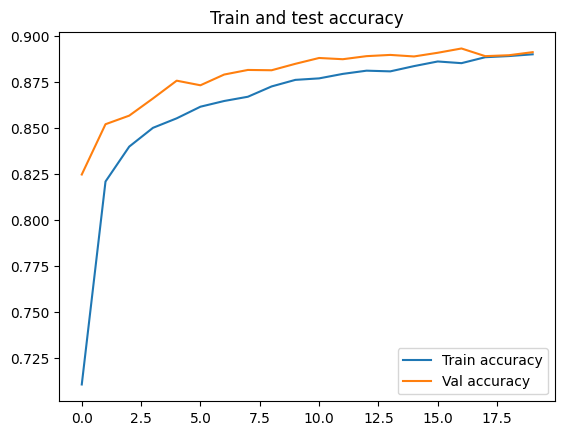

<Figure size 10000x10000 with 0 Axes>

In [11]:
plt.plot(history.history['accuracy'], label = 'Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val accuracy')
plt.title('Train and test accuracy')
plt.legend()
plt.figure(figsize = (100,100))
plt.show()

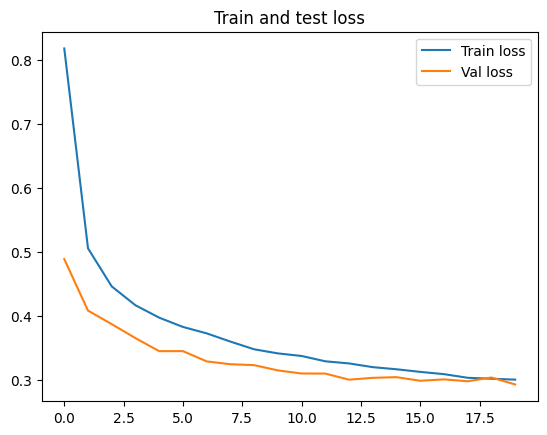

<Figure size 20000x20000 with 0 Axes>

In [12]:
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Val loss')
plt.title('Train and test loss')
plt.legend()
plt.figure(figsize = (200,200))
plt.show()